In [54]:
# callibration
# load model - separate test in two sets
# print probs on test, then calculate accuracy on test
# callibrate - hyperparameter
#ece - expected callibration error


In [ ]:
# model = MLP()                                # must match the saved model's architecture
# state = torch.load("mlp_weights.pth", map_location="cpu")
# model.load_state_dict(state)
# model.eval()       

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from utils import MLP
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
importlib.reload(utils) 
from utils import reliability_diagram
from pathlib import Path

In [82]:
# ===== Step 1: Model load =============
model = MLP()  # must match the saved architecture
state = torch.load("mlp_one_weights.pth", map_location="cpu")
model.load_state_dict(state)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [110]:
# Copy Cell 2
# ===== Step 2: Datasets & loaders =====

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=512, shuffle=True) # change to 128 to make loss smoother - 256 doesn't converge

In [111]:

full_testset = datasets.MNIST('./data', download=True, train=False, transform=transform)


# Split the original test set into: 5k calibration + 5k test
calibration_size = 5000
remaining_test_size = len(full_testset) - calibration_size   # 5000
generator = torch.Generator().manual_seed(42)

calibration_ds, test_ds = random_split(
    full_testset,
    [calibration_size, remaining_test_size],
    generator=generator
)

# Loaders: no shuffling for eval
calibration_loader = DataLoader(calibration_ds, batch_size=512, shuffle=False, pin_memory=True)
test_loader        = DataLoader(test_ds,        batch_size=512, shuffle=False, pin_memory=True)


In [112]:
# ===== Step 3: Helper to collect logits/labels from the entire data loader (callibration/test) =====
@torch.no_grad()
def collect_logits_and_labels(model, loader):
    model.eval()
    logits_list, labels_list = [], []
    for imgs, labels in loader:
        logits, _ = model(imgs)  # your forward returns (logits, loss/None)
        logits_list.append(logits)
        labels_list.append(labels)
    logits = torch.cat(logits_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return logits, labels

calibration_logits, calib_labels = collect_logits_and_labels(model, calibration_loader)



/Users/danijelh/ML/ml-env/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


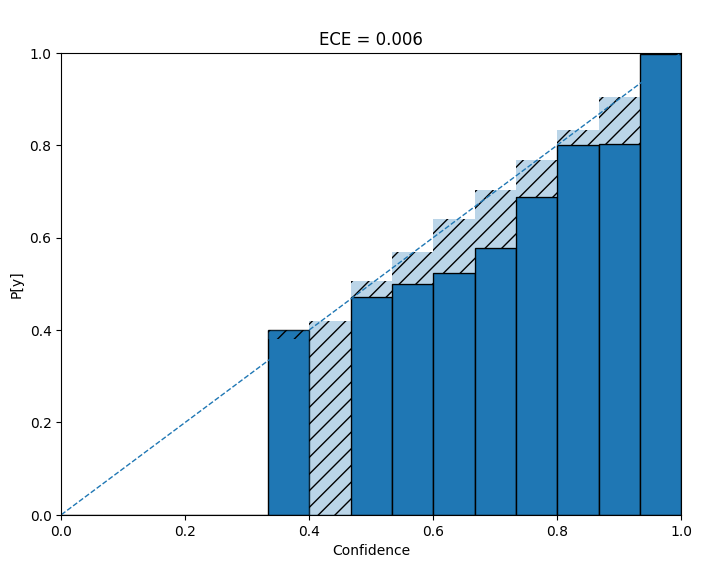

In [114]:
fig, ax = plt.subplots(figsize=(8,6))
reliability_diagram(ax, calibration_logits, calib_labels, n_bins=15, title="")

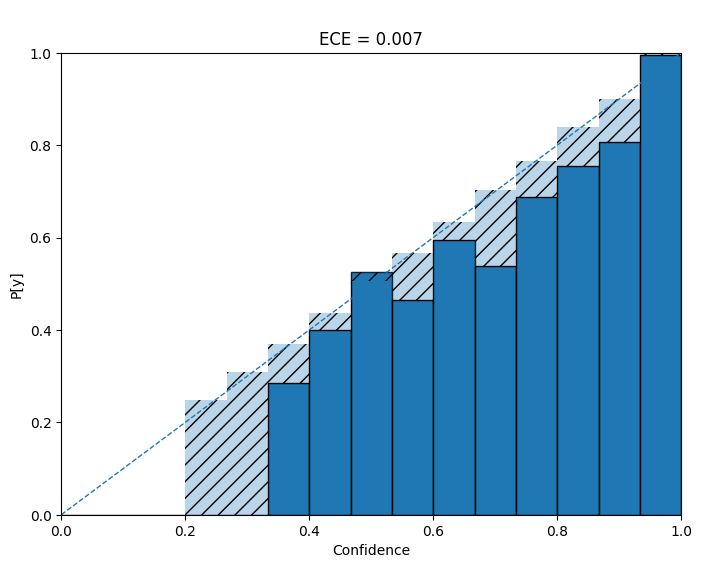

In [115]:
test_logits, test_labels = collect_logits_and_labels(model, test_loader)
fig, ax = plt.subplots(figsize=(8,6))
reliability_diagram(ax, test_logits, test_labels, n_bins=15, title="")

In [116]:
def expected_calibration_error(logits, labels, n_bins=15):
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)
        conf, pred = probs.max(dim=1)
        acc = pred.eq(labels)
        bin_edges = torch.linspace(0, 1, n_bins + 1)
        ece = torch.zeros(())
        for i in range(n_bins):
            in_bin = (conf > bin_edges[i]) & (conf <= bin_edges[i+1])
            prop = in_bin.float().mean()
            if prop > 0:
                ece += prop * torch.abs(acc[in_bin].float().mean() - conf[in_bin].mean())
        return ece.item()


In [117]:
# ===== Step 4: Temperature scaler & ECE =====
class TemperatureScaler(nn.Module):
    """Learns a single positive temperature T by optimizing NLL on calibration logits."""
    def __init__(self, init_T=1.0):
        super().__init__()
        self.log_T = nn.Parameter(torch.log(torch.tensor([init_T], dtype=torch.float32)))

    def forward(self, logits):
        T = torch.exp(self.log_T)
        return logits / T

    @property
    def T(self):
        return torch.exp(self.log_T).item()


In [118]:
def fit_temperature(val_logits, val_labels, init_T=1.0, steps=200, lr=0.05):
    """
    Learn temperature T using Adam on full-batch validation logits.
    """
    scaler = TemperatureScaler(init_T=init_T)

    opt = torch.optim.Adam([scaler.log_T], lr=lr)   # only one parameter
    ce  = nn.CrossEntropyLoss()

    for _ in range(steps):
        opt.zero_grad(set_to_none=True)
        loss = ce(scaler(val_logits), val_labels)
        loss.backward()
        opt.step()

    return scaler


In [119]:
with torch.no_grad():
    nll_before = F.cross_entropy(calibration_logits, calib_labels).item()
    ece_before = expected_calibration_error(calibration_logits, calib_labels)

scaler = fit_temperature(calibration_logits, calib_labels, init_T=1.0)

with torch.no_grad():
    nll_after = F.cross_entropy(scaler(calibration_logits), calib_labels).item()
    ece_after = expected_calibration_error(scaler(calibration_logits), calib_labels)

print(f"Learned temperature T = {scaler.T:.4f}")
print(f"Calibration NLL: {nll_before:.4f} -> {nll_after:.4f}")
print(f"Calibration ECE: {ece_before:.4f} -> {ece_after:.4f}")


Learned temperature T = 1.2444
Calibration NLL: 0.0617 -> 0.0591
Calibration ECE: 0.0057 -> 0.0028


In [120]:
# ===== Step 7: Use in inference & save temperature =====
@torch.no_grad()
def predict_proba_calibrated(model, imgs, scaler):
    model.eval()
    logits, _ = model(imgs)
    logits = scaler(logits)
    return F.softmax(logits, dim=1)

torch.save({"T": scaler.T}, "temperature_scaling.pth")


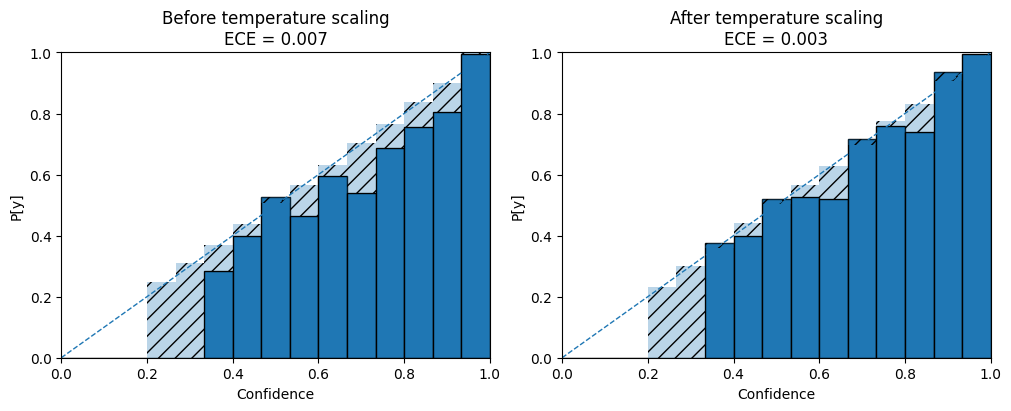

In [121]:
test_logits, test_labels = collect_logits_and_labels(model, test_loader)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
reliability_diagram(axes[0], test_logits, test_labels, n_bins=15, title="Before temperature scaling")
reliability_diagram(axes[1], scaler(test_logits), test_labels, n_bins=15, title="After temperature scaling")
plt.savefig("reliability_mnist_before_after.png", dpi=200)
plt.show()

In [122]:
# EVALUATE CALIBRATED MODEL
# raw mlp = 'accuracy': 0.9786434173583984,
# 'f1_macro': 0.9786311984062195,
#  'loss': 0.06688824575394392
# we generally do not expect significant shifts in accuracy. 
importlib.reload(utils) 
from utils import evaluate
evaluate('test', model, train_loader, test_loader, num_classes = 10, scaler= scaler)

{'accuracy': 0.9764822721481323,
 'f1_macro': 0.9762927293777466,
 'confusion_matrix': tensor([[447,   0,   1,   1,   0,   0,   0,   1,   1,   0],
         [  0, 549,   1,   0,   0,   0,   1,   1,   1,   0],
         [  2,   3, 486,   0,   0,   0,   1,   2,   1,   0],
         [  0,   0,   4, 509,   0,   7,   0,   5,   1,   4],
         [  0,   0,   3,   0, 489,   0,   3,   2,   1,   3],
         [  2,   0,   0,   2,   0, 440,   4,   1,   0,   0],
         [  3,   0,   1,   0,   4,   5, 445,   0,   2,   0],
         [  1,   4,   3,   0,   0,   0,   0, 523,   0,   0],
         [  3,   0,   1,   0,   1,   2,   1,   1, 496,   3],
         [  2,   3,   0,   4,   9,   1,   0,   3,   2, 498]]),
 'loss': 0.07274422869086265}

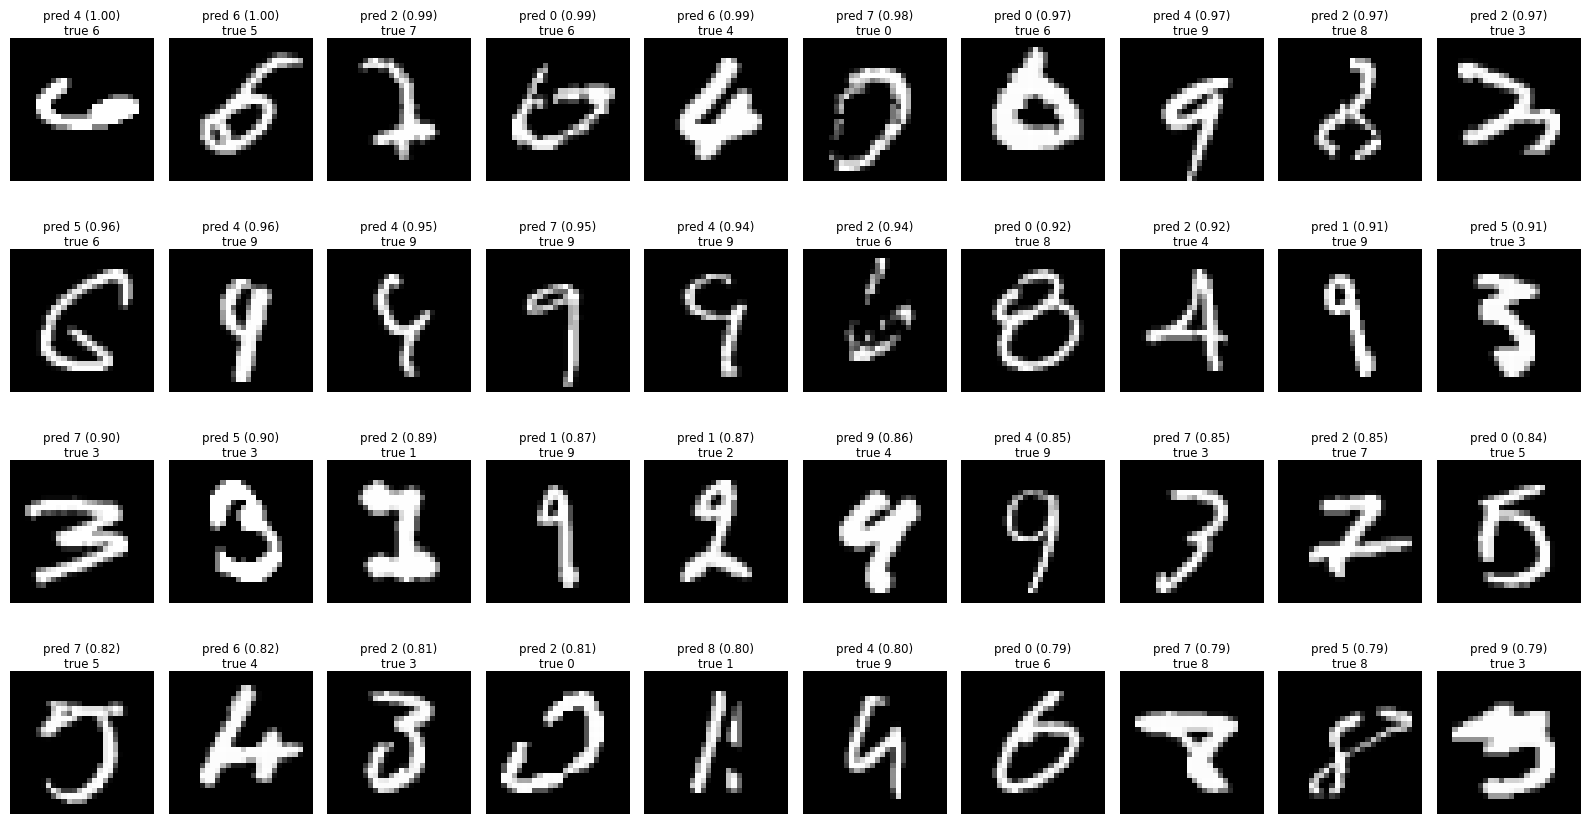

In [123]:
# we expect less overconfident wrong predictions
from utils import collect_misclassified, show_misclassified
importlib.reload(utils) 
records = collect_misclassified(model, test_loader, scaler=scaler)
show_misclassified(records, n=40)

In [126]:
# --- Load saved OOD datasets and create DataLoaders ---

importlib.reload(utils) 
from utils import OODDataset



# Your transform (same style as MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# --- Choose what you want to load ---
root = Path("./data/ood")

# 1) Separate datasets + loaders
ds_gauss   = OODDataset(root / "ood_gaussian.pt",          transform=transform)
ds_lines   = OODDataset(root / "ood_horizontal_lines.pt",  transform=transform)
ds_spiral  = OODDataset(root / "ood_spiral.pt",            transform=transform)
ds_checker = OODDataset(root / "ood_checkerboard.pt",      transform=transform)

loader_gauss   = DataLoader(ds_gauss,   batch_size=64, shuffle=False)
loader_lines   = DataLoader(ds_lines,   batch_size=64, shuffle=False)
loader_spiral  = DataLoader(ds_spiral,  batch_size=64, shuffle=False)
loader_checker = DataLoader(ds_checker, batch_size=64, shuffle=False)


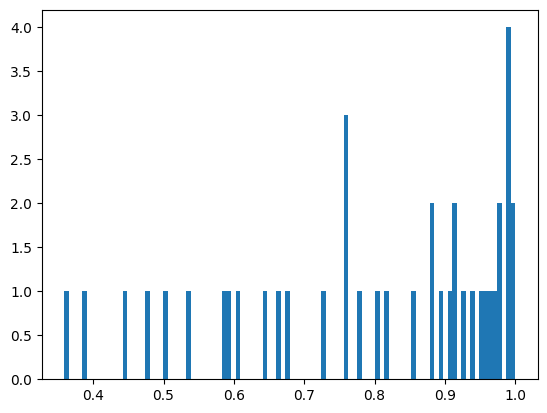

In [127]:
# plot confidences of predictions
all_confs = []
with torch.inference_mode():                
    for imgs, label in loader_lines:
        logits, _ = model(imgs)
        logits = scaler(logits)
        probs = torch.softmax(logits, dim=1)
        conf, pred = probs.max(dim=1) 
        all_conf = all_confs + conf.tolist()


plt.hist(all_conf, bins=100);    

In [ ]:
# doesn't really solve anything! 